In [1]:
import os
import json
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import statistics

from scipy.stats import ttest_ind, shapiro, mannwhitneyu


In [2]:

path = r'corpus_finished_new'

# Load German tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('de_core_news_md')

# Function to extract nouns from a text
def extract_nouns(text):
    doc = nlp(text)
    return [token.text for token in doc if token.pos_ == 'NOUN']

# Initialize data structures
nouns_gender = {'m': Counter(), 'w': Counter()}
noun_ratios_gender = {'m': [], 'w': []}
not_counted = []

# Iterate over .json files
for filename in os.listdir(path):
    if filename.endswith('.json'):
        with open(os.path.join(path, filename), 'r', encoding='utf-8') as f:
            data = json.load(f)
            gender = data['gender']
            poem_text = ' '.join(line['text'] for line in data['poem'].values())
            nouns = extract_nouns(poem_text)
            try:
                ratio = len(nouns) / len(poem_text.split())
                nouns_gender[gender].update(nouns)
                noun_ratios_gender[gender].append(ratio)
            except:
                not_counted.append(filename)

# Calculate average noun ratios for each gender and category
average_ratios_gender = {gender: sum(ratios) / len(ratios) for gender, ratios in noun_ratios_gender.items()}

all_genders = sorted(list(average_ratios_gender.keys()))


# Print the overall, median, minimum and maximum noun ratio for each gender
for gender in all_genders:
    all_ratios = noun_ratios_gender[gender]
    print(f'Gender: {gender}')
    print('Overall average relative noun ratio:', sum(all_ratios) / len(all_ratios))
    print('Median relative noun ratio:', statistics.median(all_ratios))
    print('Minimum relative noun ratio:', min(all_ratios))
    print('Maximum relative noun ratio:', max(all_ratios), '\n')

# Print the 10 most common nouns for each gender and selected category
for gender in all_genders:
    print(f'Gender: {gender}')
    print('10 most common nouns', nouns_gender[gender].most_common(10))


Gender: m
Overall average relative noun ratio: 0.2289099753045121
Median relative noun ratio: 0.2318840579710145
Minimum relative noun ratio: 0.0
Maximum relative noun ratio: 0.46808510638297873 

Gender: w
Overall average relative noun ratio: 0.23066545772336672
Median relative noun ratio: 0.22847256549678696
Minimum relative noun ratio: 0.0
Maximum relative noun ratio: 0.625 

Gender: m
10 most common nouns [('Wort', 238), ('Welt', 207), ('Zeit', 199), ('Licht', 177), ('Nacht', 149), ('Augen', 140), ('Hand', 139), ('Wasser', 134), ('Leben', 133), ('Himmel', 131)]
Gender: w
10 most common nouns [('Mission', 126), ('Zeit', 95), ('Augen', 82), ('Licht', 81), ('Wasser', 77), ('Nacht', 74), ('Himmel', 74), ('Hand', 68), ('Kopf', 59), ('augen', 58)]


In [3]:
# Funktion zum Durchführen des Shapiro-Wilk-Tests und zur Interpretation der Ergebnisse
def test_normality(data, sample_name):
    stat, p_value = shapiro(data)
    alpha = 0.05  # Signifikanzniveau
    print(f"Shapiro-Wilk-Test für {sample_name}:")
    print("Teststatistik:", stat)
    print("p-Wert:", p_value)
    if p_value > alpha:
        print(f"Die Substantivfrequenzen für {sample_name} sind normalverteilt.")
    else:
        print(f"Die Substantivfrequenzen für {sample_name} sind nicht normalverteilt.")

# Durchführung des Tests für beide Subsamples
test_normality(noun_ratios_gender['m'], "Sample M")
test_normality(noun_ratios_gender['w'], "Sample W")

Shapiro-Wilk-Test für Sample M:
Teststatistik: 0.9937336444854736
p-Wert: 7.798521437507588e-06
Die Substantivfrequenzen für Sample M sind nicht normalverteilt.
Shapiro-Wilk-Test für Sample W:
Teststatistik: 0.9830814003944397
p-Wert: 3.5839859968689325e-09
Die Substantivfrequenzen für Sample W sind nicht normalverteilt.


In [4]:
import scipy.stats as stats

# Perform a t-test to compare the means of the two groups
t_stat, p_val = stats.ttest_ind(noun_ratios_gender['m'], noun_ratios_gender['w'])

print('T-statistic:', t_stat)
print('p-value:', p_val)

T-statistic: -0.6228323980043629
p-value: 0.5334531824010794


In [5]:
# Perform the Mann-Whitney-U-Test to compare the distributions
u_stat, p_val = stats.mannwhitneyu(noun_ratios_gender['m'], noun_ratios_gender['w'], alternative='two-sided')

print('Mann-Whitney U-Statistik:', u_stat)
print('p-Wert:', p_val)

Mann-Whitney U-Statistik: 703465.5
p-Wert: 0.8063891449140497


In [6]:
n1 = len(noun_ratios_gender['m'])
n2 = len(noun_ratios_gender['w'])
effect_size = np.sqrt(u_stat / (n1 * n2))

print("Effektstärke (Cramer's V):", effect_size)

Effektstärke (Cramer's V): 0.7050304729235645


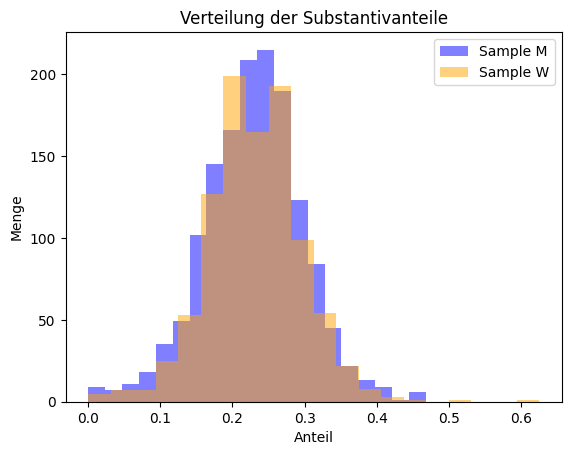

In [7]:
# Erstelle eine Figure und Axes-Objekte
fig, ax = plt.subplots()

# Plotten der Histogramme für beide Subsamples
ax.hist(noun_ratios_gender['m'], bins=20, alpha=0.5, label='Sample M', color='blue')
ax.hist(noun_ratios_gender['w'], bins=20, alpha=0.5, label='Sample W', color='orange')

# Hinzufügen von Labels und Titeln
ax.set_xlabel('Anteil')
ax.set_ylabel('Menge')
ax.set_title('Verteilung der Substantivanteile')

# Legende anzeigen
ax.legend()

# Anzeigen der Grafik
plt.show()